# Image Classification using Pre-trained Vision Transformer

##**1. Setup Environment**

In [2]:
!pip install -q datasets accelerate evaluate transformers tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [1]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import os
import glob
import torch
import random
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms

from datasets import Dataset
from datasets import load_dataset
from transformers import ViTImageProcessor
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [3]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


##**2. Load Dataset**

In [4]:
### COMPLETE THE CODE HERE
hf_dataset = load_dataset("TuyenTrungLe/vietnamese_food_images")

classes = hf_dataset["train"].features["label"].names   
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")
print(f"Train samples: {len(hf_dataset["train"])}")
print(f"Validation samples: {len(hf_dataset["validation"])}")
print(f"Test samples: {len(hf_dataset["test"])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00006.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

data/train-00001-of-00006.parquet:   0%|          | 0.00/544M [00:00<?, ?B/s]

data/train-00002-of-00006.parquet:   0%|          | 0.00/542M [00:00<?, ?B/s]

data/train-00003-of-00006.parquet:   0%|          | 0.00/577M [00:00<?, ?B/s]

data/train-00004-of-00006.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

data/train-00005-of-00006.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17581 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2515 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5040 [00:00<?, ? examples/s]

Number of classes: 30
Classes: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo']
Train samples: 17581
Validation samples: 2515
Test samples: 5040


In [6]:
class VietnameseFoodDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        ### COMPLETE THE CODE HERE
        item = self.dataset[idx]

        img_pil = item["image"]
        label_val = item["label"]

        image = img_pil.convert("RGB")
        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label_val}

##**3. Preprocessing**

In [7]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [9]:
def sample_per_class(dataset, num_samples_per_class):
    ### COMPLETE THE CODE HERE
    labels = dataset["label"]

    df = pd.DataFrame({"label": labels, "index": range(len(labels))})

    sampled_indices = df.groupby("label").head(num_samples_per_class)['index'].tolist()

    return dataset.select(sampled_indices)

sampled_train_hf_dataset = sample_per_class(hf_dataset["train"], 100)
sampled_validation_hf_dataset = sample_per_class(hf_dataset["validation"], 10)
sampled_test_hf_dataset = sample_per_class(hf_dataset["test"], 10)

train_dataset = VietnameseFoodDataset(sampled_train_hf_dataset, transform=train_transforms)
valid_dataset = VietnameseFoodDataset(sampled_validation_hf_dataset, transform=test_transforms)
test_dataset = VietnameseFoodDataset(sampled_test_hf_dataset, transform=test_transforms)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 3000
Validation samples: 300
Test samples: 300


## **4. Modeling**

In [10]:
id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id,label in id2label.items()}

### COMPLETE THE CODE HERE
model_id = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_id, num_labels=num_classes, id2label=id2label, label2id=label2id)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

##**5. Trainer**

In [12]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    ### COMPLETE THE CODE HERE
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [11]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir="vit_vietnamese_food",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_strategy="epoch",
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    remove_unused_columns=False,
    report_to="tensorboard"
)

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["image"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

feature_extractor = ViTImageProcessor.from_pretrained(model_id)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=feature_extractor,
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

##**6. Training**

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,3.245000,3.038432,0.576667
2,2.818500,2.636169,0.756667
3,2.418500,2.320725,0.793333
4,2.106700,2.091128,0.803333
5,1.870100,1.914664,0.826667
6,1.691300,1.789335,0.840000
7,1.551900,1.698118,0.830000
8,1.451200,1.633106,0.840000
9,1.383400,1.597704,0.840000
10,1.347400,1.584151,0.840000


TrainOutput(global_step=940, training_loss=1.988417093804542, metrics={'train_runtime': 1535.3902, 'train_samples_per_second': 19.539, 'train_steps_per_second': 0.612, 'total_flos': 2.32534309883904e+18, 'train_loss': 1.988417093804542, 'epoch': 10.0})

Using event file: ./vit_vietnamese_food/runs/Dec28_16-15-14_896f99cd5917/events.out.tfevents.1766938542.896f99cd5917.338.0
Found scalar tags (first 30): ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
Inferred steps_per_epoch = 94
Saved: results.pdf and results.png


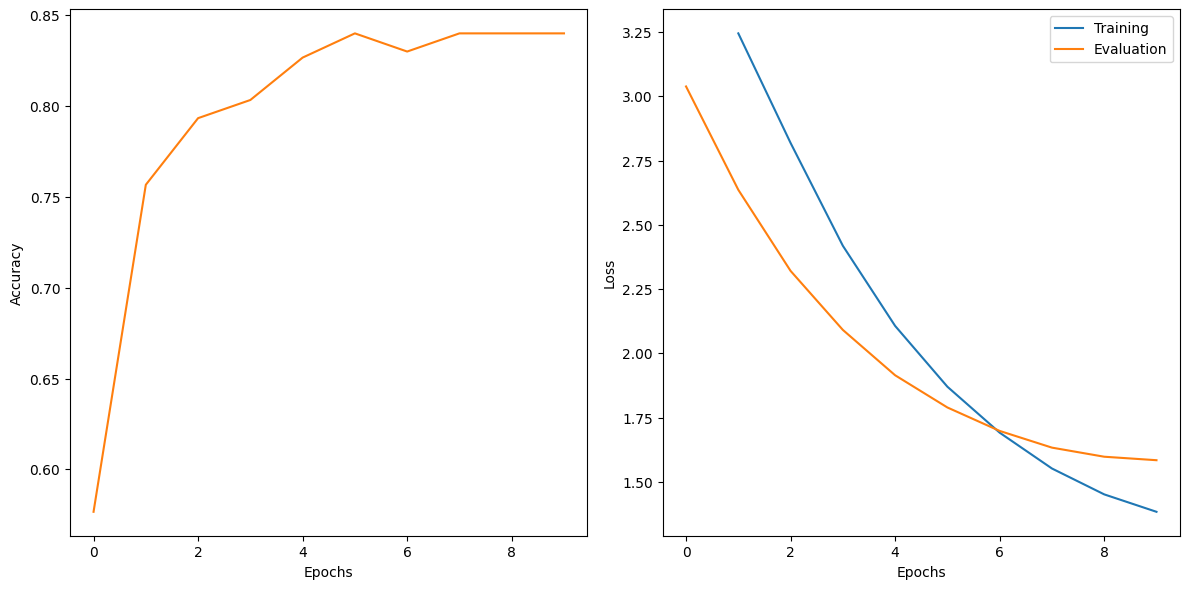

In [15]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()
    plt.tight_layout()

def pick_tag(tags, candidates):
    for c in candidates:
        if c in tags:
            return c
    return None

def read_tb_and_plot(logdir="./runs", steps_per_epoch=None):
    event_files = sorted(glob.glob(f"{logdir}/**/events.out.tfevents.*", recursive=True))
    if not event_files:
        raise FileNotFoundError(f"No TensorBoard event files found under: {logdir}")
    event_file = event_files[-1]
    print("Using event file:", event_file)

    ea = EventAccumulator(event_file, size_guidance={"scalars": 0})
    ea.Reload()
    scalar_tags = ea.Tags().get("scalars", [])
    print("Found scalar tags (first 30):", scalar_tags[:30])

    eval_acc_tag  = pick_tag(scalar_tags, ["eval/accuracy", "eval_accuracy"])
    eval_loss_tag = pick_tag(scalar_tags, ["eval/loss", "eval_loss"])
    train_loss_tag = pick_tag(scalar_tags, ["train/loss", "loss", "train_loss"])
    train_acc_tag  = pick_tag(scalar_tags, ["train/accuracy", "train_accuracy"])

    if eval_acc_tag is None or eval_loss_tag is None:
        raise ValueError(
            "Could not find eval accuracy/loss tags in TensorBoard."
            "Make sure you set report_to='tensorboard' and evaluation_strategy='epoch' (or steps)."
        )

    def get_scalar(tag):
        evs = ea.Scalars(tag)
        steps = np.array([e.step for e in evs], dtype=int)
        vals  = np.array([e.value for e in evs], dtype=float)
        idx = np.argsort(steps)
        return steps[idx], vals[idx]

    eval_steps_acc, eval_accs = get_scalar(eval_acc_tag)
    eval_steps_loss, eval_losses = get_scalar(eval_loss_tag)

    n_eval = min(len(eval_accs), len(eval_losses))
    eval_accs = eval_accs[:n_eval].tolist()
    eval_losses = eval_losses[:n_eval].tolist()

    if train_loss_tag is not None:
        train_steps, train_losses_steps = get_scalar(train_loss_tag)

        if steps_per_epoch is None:
            if len(eval_steps_loss) >= 2:
                steps_per_epoch = int(eval_steps_loss[1] - eval_steps_loss[0])
                print("Inferred steps_per_epoch =", steps_per_epoch)
            else:
                steps_per_epoch = max(train_steps.max(), 1)
                print("Fallback steps_per_epoch =", steps_per_epoch)

        epoch_ids = (train_steps // steps_per_epoch).astype(int)

        train_losses = []
        for e in range(n_eval):
            mask = (epoch_ids == e)
            if mask.any():
                train_losses.append(float(train_losses_steps[mask].mean()))
            else:
                train_losses.append(float("nan"))
    else:
        train_losses = [float("nan")] * n_eval

    if train_acc_tag is not None:
        _, train_accs = get_scalar(train_acc_tag)
        train_accs = train_accs[:n_eval].tolist()
    else:
        train_accs = [float("nan")] * n_eval

    num_epochs = n_eval
    plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

    plt.savefig("results.pdf")
    plt.savefig("results.png")
    print("Saved: results.pdf and results.png")

read_tb_and_plot(logdir="./vit_vietnamese_food/runs", steps_per_epoch=None)

##**7. Evaluation**

In [16]:
outputs = trainer.predict(test_dataset)

In [17]:
outputs.metrics

{'test_loss': 1.805834174156189,
 'test_accuracy': 0.8366666666666667,
 'test_runtime': 7.6866,
 'test_samples_per_second': 39.029,
 'test_steps_per_second': 1.301}

In [20]:
import sys
sys.exit()

SystemExit: 

torch.__version__

In [ ]:
import sys

try:
)
except SystemExit:
    print("Caught SystemExit")

NameError: name 'some_function' is not defined

In [21]:
torch.__version__

'2.9.0+cu126'